In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import iminuit
from iminuit import Minuit
from iminuit.cost import LeastSquares

In [2]:
file = 'VarAstro_Star_61740_Obs_110560_2025-10-20.txt'
transit_data = np.loadtxt(file, skiprows=14)
#print(transit_data)
#print(np.shape(transit_data))

Link stella: https://simbad.cds.unistra.fr/simbad/sim-basic?Ident=HD189733&submit=SIMBAD+search

Link pianeta: https://exoplanet.eu/catalog/hd_189733_ab--307/, https://exoplanetarchive.ipac.caltech.edu/overview/HD%20189733

Plot con andamento teorico, evidenziare che pt non si dispongono, plot con limb darkening (atmosfere stelle hanno lunghezza ottica diversa)

***

$\displaystyle T_\text{dur} = \frac{P}{\pi} \arcsin{\left(\frac{\sqrt{(R_* + R_P)^2 - a^2 \cos{i}^2}}{a}\right)}$

$P$ è il periodo, $i$ angolo di inclinazione, $a$ è il semiasse maggiore

***

Per $a \gg R_* \gg R_P$, $\displaystyle T_\text{dur} \simeq \frac{P}{\pi} \sqrt{\left(\frac{R_*}{a}\right)^2 -\cos{i}^2}$

Sapendo il tipo di stella, $M_*, R_*$ sono ricavabili dal diagramma HR

$T_\text{dur}, P$ sufficienti a dedurre l'angolo

La transit depth da rapporto tra i raggi: $\frac{\Delta F}{F} = \frac{R_P^2}{R_*^2}$

In [3]:
#Conversione magnitudine-flusso: chiesto dati a Vittorio Tortorella
file_fluxes = 'curva_luce_differenziale.txt'
fluxes = np.loadtxt(file_fluxes, skiprows=1)
print(fluxes)
print(np.shape(fluxes))

[[2.46095729e+06 2.98837459e+06 8.64253213e+05 9.94834941e-01]
 [2.46095729e+06 3.00350966e+06 8.50857032e+05 1.01561578e+00]
 [2.46095729e+06 2.97546782e+06 8.46102052e+05 1.01178796e+00]
 ...
 [2.46095741e+06 2.77751898e+06 7.54403450e+05 1.05927901e+00]
 [2.46095741e+06 2.77491145e+06 7.82652962e+05 1.02008625e+00]
 [2.46095741e+06 2.74123820e+06 7.78004420e+05 1.01372862e+00]]
(485, 4)


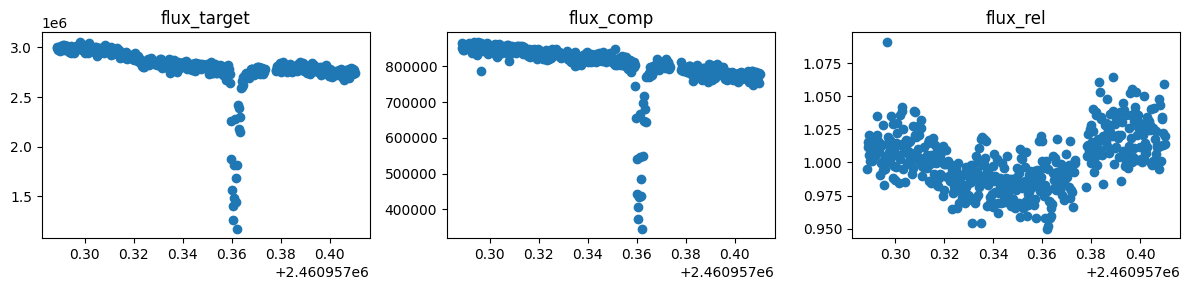

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12, 3))

ax1.scatter(fluxes[:, 0], fluxes[:, 1])
ax1.set_title('flux_target')
ax2.scatter(fluxes[:, 0], fluxes[:, 2])
ax2.set_title('flux_comp')
ax3.scatter(fluxes[:, 0], fluxes[:, 3])
ax3.set_title('flux_rel')

plt.tight_layout()
plt.show()

Sostanzialmente quello fatto prima è inutile, noi dobbiamo ragionare in termini di flusso, non di magnitudine - perché la magnitudine non è linare. Flux rel è il rapporto tra flux target (la mia stella) e flux comp (stella di comparazione)

In [5]:
df = pd.DataFrame(fluxes)
df.columns = ('jd', 'flux_target', 'flux_comp', 'flux_rel')
df['delta_jd'] = df.loc[:, 'jd'] - df.at[0, 'jd'] #tempo è espresso in JD (Julian Day)
df['time']= df.loc[:, 'delta_jd']*86400 #per transformare l'intervallo di tempo in secondi va moltiplicato per 86400

df

,jd,flux_target,flux_comp,flux_rel,delta_jd,time
0,2.460957e+06,2.988375e+06,864253.212792,0.994835,0.000000,0.000000
1,2.460957e+06,3.003510e+06,850857.032319,1.015616,0.000242,20.941991
2,2.460957e+06,2.975468e+06,846102.052065,1.011788,0.000485,41.899994
3,2.460957e+06,2.993793e+06,856728.636066,1.005392,0.000727,62.854980
4,2.460957e+06,2.999282e+06,845414.238789,1.020716,0.000971,83.863999
...,...,...,...,...,...,...
480,2.460957e+06,2.746320e+06,779782.078643,1.013293,0.120732,10431.207995
481,2.460957e+06,2.732141e+06,769137.687283,1.022012,0.120975,10452.199996
482,2.460957e+06,2.777519e+06,754403.450482,1.059279,0.121218,10473.217987
483,2.460957e+06,2.774911e+06,782652.962095,1.020086,0.121460,10494.158971


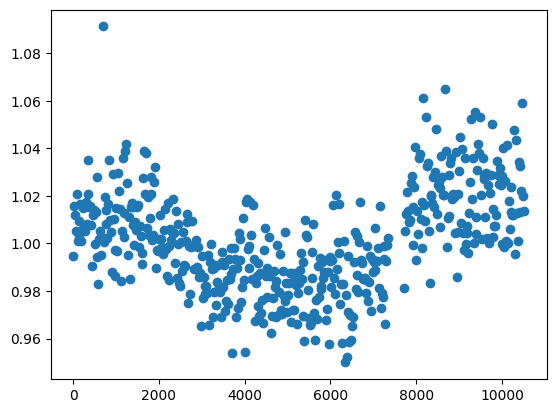

In [6]:
plt.scatter(df['time'], df['flux_rel'])
plt.show()

#dati storti quindi li raddrizzo
#il flusso tra l'altro non richiede l'inversione rognosa delle y

In [7]:
def line(x, m, b):
    return m*x + b

flux10 = df.loc[:, 'flux_rel'].to_numpy()
flux10 = np.concatenate([flux10[:10], flux10[-10:]])

time10 = df.loc[:, 'time'].to_numpy()
time10 = np.concatenate([time10[:10], time10[-10:]])

sigma_flux10 = np.ones_like(flux10)
leastsquares10 = LeastSquares(time10, flux10, sigma_flux10, line)

fit10 = Minuit(leastsquares10, m=0.0, b=0.0)
fit10.migrad()
fit10.hesse()

print(fit10.values)
print(fit10.errors)

#farlo con Minuit ha più senso; quello che noi stiamo facendo è banalmente un fit lineare per raddrizzare i dati
#siccome non abbiamo idea sugli errori, prendiamo come punti solo i primi e gli ultimi 10 punti
#perchè prendendo più punti saranno influenzati dal fatto che noi non abbiamo (ancora) idea di quale sia la forma funzionale

<ValueView m=1.674890837134865e-06 b=1.007798332695096>
<ErrorView m=4.330507992879252e-05 b=0.31911980609944446>


In [8]:
mfit10 = fit10.values['m']
bfit10 = fit10.values['b']

df['flux_fit'] = df.loc[:, 'flux_rel'] - mfit10*df.loc[:, 'time']

df

,jd,flux_target,flux_comp,flux_rel,delta_jd,time,flux_fit
0,2.460957e+06,2.988375e+06,864253.212792,0.994835,0.000000,0.000000,0.994835
1,2.460957e+06,3.003510e+06,850857.032319,1.015616,0.000242,20.941991,1.015581
2,2.460957e+06,2.975468e+06,846102.052065,1.011788,0.000485,41.899994,1.011718
3,2.460957e+06,2.993793e+06,856728.636066,1.005392,0.000727,62.854980,1.005287
4,2.460957e+06,2.999282e+06,845414.238789,1.020716,0.000971,83.863999,1.020575
...,...,...,...,...,...,...,...
480,2.460957e+06,2.746320e+06,779782.078643,1.013293,0.120732,10431.207995,0.995821
481,2.460957e+06,2.732141e+06,769137.687283,1.022012,0.120975,10452.199996,1.004506
482,2.460957e+06,2.777519e+06,754403.450482,1.059279,0.121218,10473.217987,1.041738
483,2.460957e+06,2.774911e+06,782652.962095,1.020086,0.121460,10494.158971,1.002510


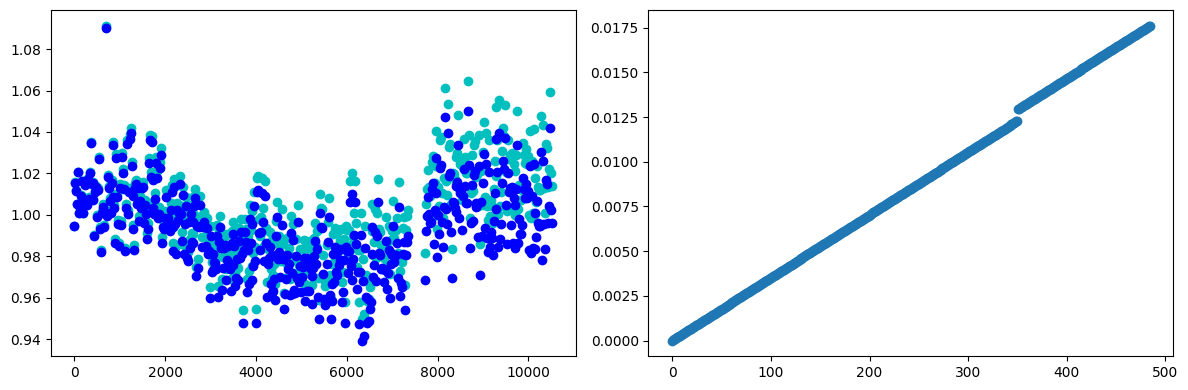

In [10]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

ax1.scatter(df['time'], df['flux_rel'], c='c')
ax1.scatter(df['time'], df['flux_fit'], c='b')

ax2.scatter(df.index, df['flux_rel']-df['flux_fit'])

plt.tight_layout()
plt.show()

#l'unica cosa che non mi spiego è questo stupido gap

(quando avremo finito mettiamo qua i calcoli fatti per ricavare la relazione funzionale)

$\displaystyle F(t)=\begin{cases}
    F_0 & t \leq t_1 \land t \geq t_4 & \text{(pre- e post-transito)} \\
    F_0 - \delta \left(\frac{t - t_1}{\tau}\right) & t_1 < t \leq t_2 & \text{(ingresso)}\\
    F_0 - \delta & t_2 < t \leq t_3 & \text{(eclissi)}\\
    F_0 + \delta \left(1 - \frac{t - t_3}{\tau}\right) & t_3 < t < t_4 & \text{(uscita)}\\
    \end{cases}$

* $F_0$ livello normale del flusso, da normalizzare
* $t_0$ tempo del minimo, centro transito
* $\delta$ profondità del flusso
* $\tau = t_2 - t_1 = t_4 - t_3$, durata in-out

Nella scrittura del modello eviterei $\tau$ perché (per motivi di errorri sul flusso) non è detto che le due differenze siano uguali

In [12]:
#numpy.piecewise(x, condlist, funclist, *args, **kw)

def piecewise(t, F0, deltaF, t1, t2, t3, t4):
    tau12 = t2 - t1
    tau34 = t4 - t3
    return np.piecewise(t,
        [
            (t <= t1) | (t >= t4),
            (t > t1) & (t <= t2),
            (t > t2) & (t <= t3),
            (t > t3) & (t < t4)
        ],
        [
            lambda t: F0,
            lambda t: F0 - deltaF * (t - t1) / tau12,
            lambda t: F0 - deltaF,
            lambda t: F0 - deltaF + deltaF * (t - t3) / tau34
        ])

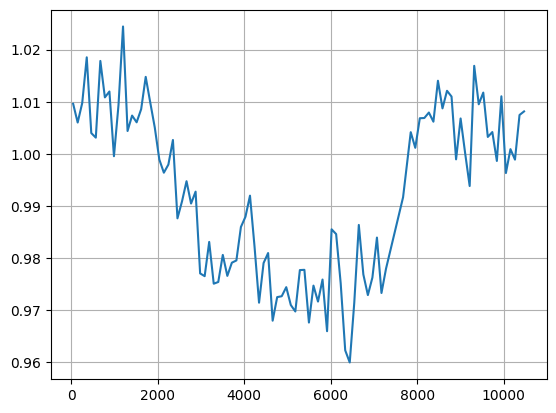

In [31]:
#dato che Minuit vuole un first guess per ogni parametro, facciamo una media ogni 5pt per avere un'idea approssimata dei vari F0, tau
#485/5=97
t5 = np.mean(np.reshape(df['time'], (97, 5)), axis=1)
flux5 = np.mean(np.reshape(df['flux_fit'], (97, 5)), axis=1)

plt.plot(t5, flux5)
plt.grid()
plt.show()

In [41]:
#vediamo quindi i nostri first guesses
#F0, deltaF, t1, t2, t3, t4
guesses = [1.005, 0.03, 2000, 3000, 7000, 8000]

In [49]:
time = df['time']
flux = df['flux_fit']
sigmaflux = np.ones_like(flux)

leastsquaresflux = LeastSquares(time, flux, sigmaflux, piecewise)
mF = Minuit(leastsquaresflux,
            F0=guesses[0], deltaF=guesses[1], t1=guesses[2], t2=guesses[3], t3=guesses[4], t4=guesses[5])
mF.migrad()
mF.hesse()

for i in range(len(mF.values)):
    print(f'{mF.values[i]:.5f} +- {mF.errors[i]:.5f}')

1.00725 +- 0.07073
0.03103 +- 0.10159
1788.86360 +- 12365.01739
3318.16095 +- 11702.01461
7265.81798 +- 13694.72721
8133.15918 +- 9733.10331


`F0` ha un valore e un errore sostanzialmente accettabili, tutti gli altri dati hanno errori troppo alti.

Gli errori sui singoli punti per quanto riguarda il flusso possiamo calcolarli considerando i punti come variabili gaussiane distribuite attorno al valore medio $\mu = F(t)$, l'errore diventa allora $\sigma$.

A questo punto io proseguirei usando magari il pacchetto `batman` per il transito di esopianeti, e usarlo per stimare parametri interessanti, usando come dati quelli ottenuti da questo.

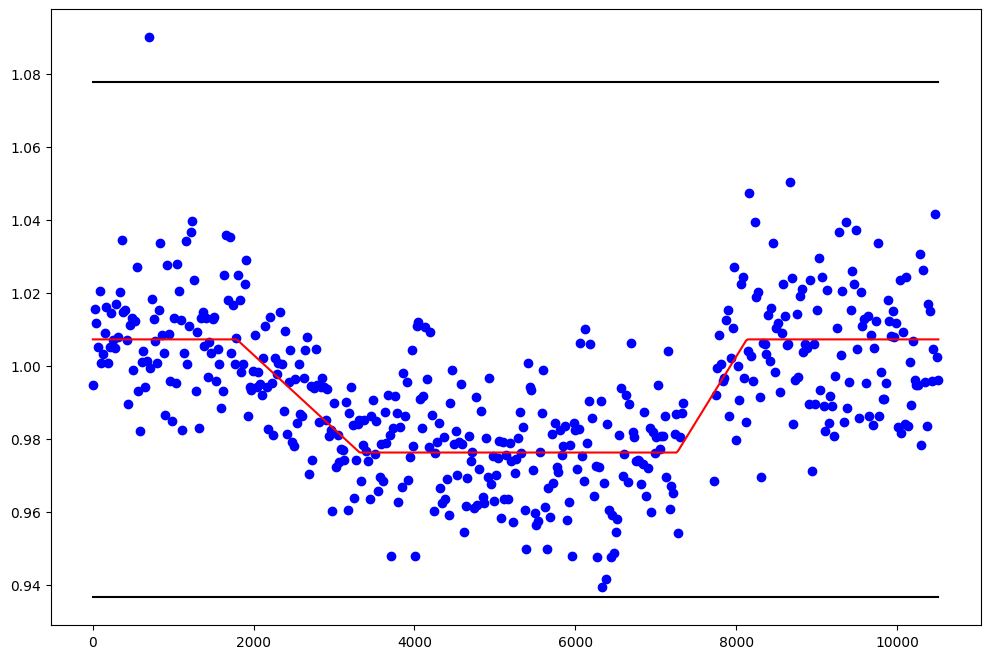

In [64]:
Ft = piecewise(np.array(time), *mF.values)

params = np.array(mF.values[:])
errs   = np.array(mF.errors[:])
params_low = params - errs
params_high  = params + errs

Ft_low = piecewise(np.array(time), *params_low)
Ft_high = piecewise(np.array(time), *params_high)

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(time, flux, c='b')
ax.plot(time, Ft, c='r')
ax.plot(time, Ft_low, c='k')
ax.plot(time, Ft_high, c='k')
plt.show()